# Import Config


In [1]:
# Load the YAML file
# Import config
import sys 
sys.path.append("C:/Users/isxzl/OneDrive/Code/VICReg-BarlowTwins-Ablation-Study/autoSSL")
sys.path.append("C:/Users/isxzl/OneDrive/Code/VICReg-BarlowTwins-Ablation-Study/")

import yaml
from torchvision.transforms import RandomRotation,GaussianBlur,ColorJitter
from autoSSL.evaluate import eval_KNN,eval_linear,eval_KNNplot,pipe_collate
from autoSSL.models import BarlowTwins, BYOL, MoCo, SimCLR, SimSiam, VICReg ,pipe_model 
from autoSSL.utils import embedding_feature,ck_callback,dict2transformer,join_dir,ContinuousCSVLogger  
from autoSSL.data import PipeDataset
from autoSSL.train import Trainer
import pytorch_lightning as pl

with open('../experiment/global.yaml', 'r') as file:
    config = yaml.safe_load(file)


# Define global view function
SSL_augmentation = {
    'RandomResizedCrop': {'size': (64, 64)},
    'RandomApply':{'transforms':[RandomRotation(degrees=90)], 'p':0.8},
    'RandomHorizontalFlip': {'p': 0.5},
    'RandomVerticalFlip':  {'p':0.5},
    'RandomApply':{'transforms': [ColorJitter(brightness=0.04,contrast=0.04,saturation=0.02,hue=0.01)], 'p':0.8},
    'RandomGrayscale' :{'p':0.2},
    'RandomSolarize':{'threshold':128, 'p':0.1},
    'RandomApply':{'transforms':[GaussianBlur(kernel_size=3,sigma=(0.2, 2))],'p':0.8},
    'ToTensor': {},
    'Normalize': {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
}



C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import the dataset

In [ ]:
# THIS IS THE CODE TO LOAD DATASET


pipe_data_test= PipeDataset(input_dir=config["dataset_dir"], 
      augmentation=dict2transformer(SSL_augmentation,view=config["view"]), 
      samples=config["samples"], batch_size=config["batch_size"], shuffle=config["shuffle"], 
      drop_last=config["drop_last"], num_workers=config["num_workers"] 
    ) 
        
        

#### Lets Explore the dataset

In [20]:

print(f".pipe_data :{len(pipe_data_test)}")     # get dataset class
pipe_data_test[2]


.pipe_data :50000


([tensor([[[-0.3198, -0.1486, -0.1828,  ..., -0.2684, -0.3198, -0.3369],
           [-0.2342, -0.0801, -0.2171,  ..., -0.2513, -0.3027, -0.3198],
           [-0.0116,  0.0227, -0.3198,  ..., -0.2171, -0.2856, -0.3198],
           ...,
           [-0.0801, -0.0801, -0.0629,  ...,  0.0398,  0.0056,  0.0056],
           [-0.0972, -0.0801, -0.0629,  ...,  0.0569,  0.0227,  0.0227],
           [-0.0972, -0.0972, -0.0629,  ...,  0.0569,  0.0227,  0.0227]],
  
          [[-0.3375, -0.2325,  0.0651,  ..., -0.8627, -0.8452, -0.8452],
           [-0.2500, -0.1450,  0.1176,  ..., -0.8102, -0.7927, -0.7752],
           [-0.0049,  0.0651,  0.1352,  ..., -0.6527, -0.6176, -0.6001],
           ...,
           [ 0.1527,  0.1527,  0.1702,  ...,  0.1352,  0.1527,  0.1527],
           [ 0.1527,  0.1527,  0.1702,  ...,  0.1352,  0.1527,  0.1527],
           [ 0.1527,  0.1527,  0.1702,  ...,  0.1352,  0.1527,  0.1527]],
  
          [[-1.2641, -1.1596, -0.8633,  ..., -1.1421, -1.1596, -1.1596],
           

#### Lets check and plot the augmentation with two views

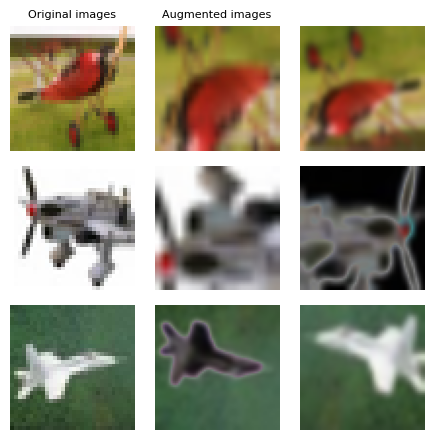

In [21]:

pipe_data_test.plot([2,3,4])


#### If you want to get a dataloader or dataset (for pytorch class)

In [22]:

pipe_data_test.dataloader  # get dataloader  
print(f".dataset :{len(pipe_data_test.dataset)}")     # get dataset class



.dataset :50000


#### If you want to get a narray list (for sklearning)

In [23]:
temp=pipe_data_test.array
print(f".array :{len(temp)}")       #get array.
print(f".array[0] :{len(temp[0])}")       #get array.

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.60it/s]


.array :3
.array[0] :2


# Create a Model!!

In [2]:

# List of model names
model_list = ["MoCo", "BYOL", "SimCLR", "SimSiam", "BarlowTwins", "VICReg"]
backbones =  ["resnet18", "resnet18_pretrained", "resnet50", "resnet50_pretrained", 
             "efficientnet_b5", "efficientnet_b5_pretrained", "mobilenet_v3", 
             "mobilenet_v3_pretrained", "vit_64", "vit_224"]
model_list = ["MoCo", "BYOL", "SimCLR", "SimSiam", "BarlowTwins", "VICReg"]
prjhead_dims = [None, 512, 1024]
stop_gradients = [False, True]
prjhead_dims = [None, 512, 1024]

model=pipe_model(name=model_list[0], backbone=backbones[0], stop_gradient=stop_gradients[0], prjhead_dim=prjhead_dims[1])


# Training the data!

In [27]:
epoches=[2,4,6]
accelerators=["cpu","cuda"]

trainer = pl.Trainer(
    max_epochs=epoches[0],accelerator=accelerators[0], 
    callbacks=[ck_callback("your_dir_save_log")],
    logger=ContinuousCSVLogger(save_dir="your_dir_save_log",name="my_log")
)



#for train
trainer.fit(model, pipe_data_test.dataloader)  


# FOR LOAD PREVIOUS WEIGHT
#trainer.fit(pmodel, pdata.dataloader,ckpt_path="your_dir_save_log//checkpoints-epoch=02-train_loss=20.89.ckpt"))  



GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                     | Type               | Params
----------------------------------------------------------------
0 | backbone                 | Sequential         | 11.2 M
1 | projection_head          | MoCoProjectionHead | 328 K 
2 | backbone_momentum        | Sequential         | 11.2 M
3 | projection_head_momentum | MoCoProjectionHead | 328 K 
4 | criterion                | NTXentLoss         | 0     
----------------------------------------------------------------
11.5 M    Trainable params
11.5 M    Non-trainable params
23.0 M    Total params
92.039    Total estimated model params size (MB)


Epoch 0:   4%|██▋                                                              | 4/98 [00:23<09:18,  5.94s/it, v_num=0]

C:\Users\isxzl\anaconda3\envs\AutoGPT\lib\site-packages\pytorch_lightning\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Evaluate the model!!!

In [3]:
# Define global view function
test_augmentation = {
    'RandomResizedCrop': {'size': (64, 64)},
    'ToTensor': {},
    'Normalize': {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
}

pipe_data_test =PipeDataset(
    input_dir="../../Datasets/cifar10/test/", 
    samples=1000, 
    augmentation=dict2transformer(test_augmentation), 
    batch_size=32,
    shuffle=True,
    #collate_fn=collate_fn,
    drop_last=True,
    num_workers=4,

) 

eval_linear(pipe_data_test,models=model,split=0.8,device="cuda") 
#eval_linear(pipe_data_test,models=model,test=pipe_data_test,device="cuda") 
        


#### Evaluate by KNN

Load the testing dataset to array


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.79it/s]


embedding the test dataset
truck\0705.png


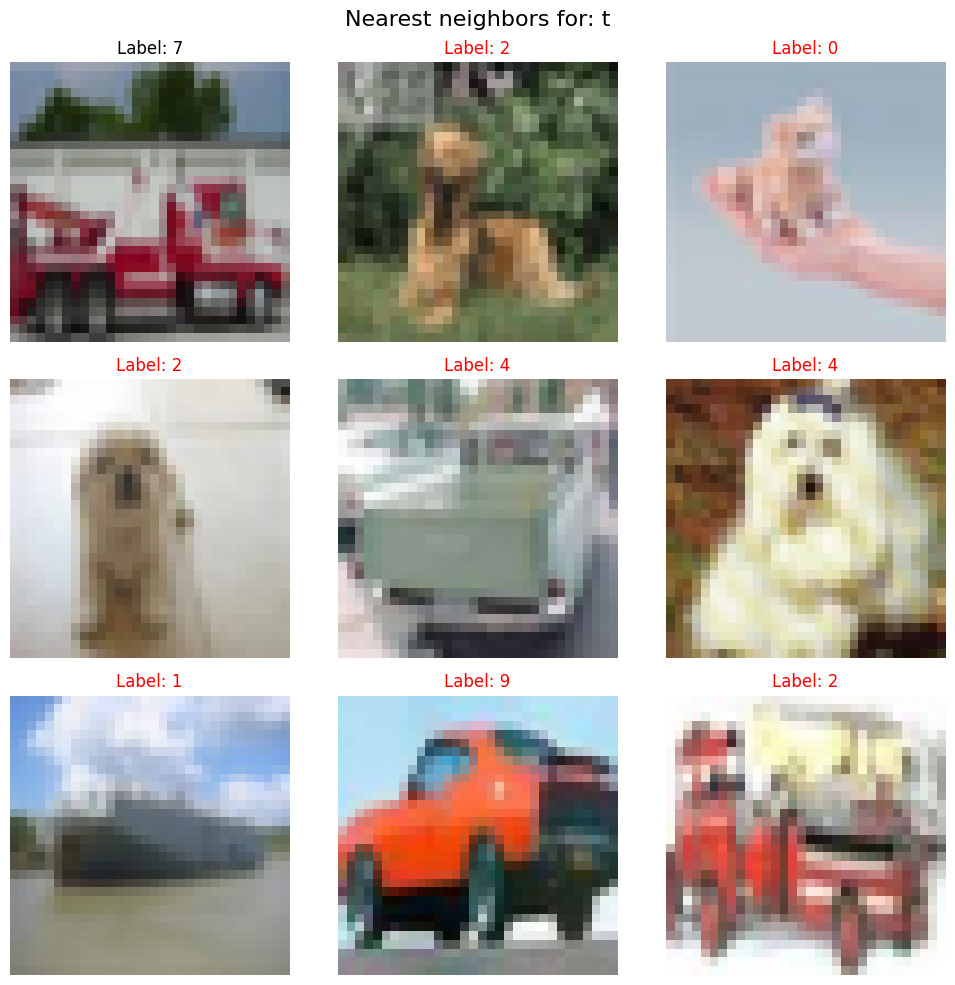

In [21]:
eval_KNNplot(pipe_data_test,embedding_model=model,samples=1,device="cuda")

# Other methods

In [ ]:

eval_KNN(pipe_data_test,embedding_model=model,split=0.8,device="cuda") 
eval_KNN(pipe_data_test,embedding_model=model,test=pipe_data_test,device="cuda")   


tensor([1, 2, 3])
